In [116]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.model_selection import learning_curve
from sklearn import metrics

In [76]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn import model_selection

In [77]:
from sklearn.dummy import DummyClassifier

## Data Load

In [78]:
data_path = "../data/uci_data.xls"

In [79]:
df = pd.read_excel(data_path, header=0, index_col=0, skiprows=1)
df = df.rename(columns={'PAY_0': 'PAY_1'})

## Data cleaning

In [80]:
# I set all invalid values to 'other'
df.loc[~(df['EDUCATION'].isin([1, 2, 3, 4])), 'EDUCATION'] = 4
df.loc[~(df['MARRIAGE'].isin([1, 2, 3])), 'MARRIAGE'] = 3

# PAY_* fuera de rango
paux = ~(df['PAY_1'].isin([-1,0,1,2,3,4,5,6,7,8,9]))
for i in range(2, 7):
    paux = paux | ~(df['PAY_' + str(i)].isin([-1,0,1,2,3,4,5,6,7,8,9]))
    
df = df[~paux]

## Data split

In [81]:
train, test = train_test_split(df, test_size=0.2, random_state=42)
X_train = train.drop(columns=("default payment next month"))
y_train = train[["default payment next month"]]
X_test = test.drop(columns=("default payment next month"))
y_test = test[["default payment next month"]]

In [82]:
train.head()

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_1,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
ID,,,,,,,,,,,,,,,,,,,,,
29366,50000,1,2,2,24,0,0,0,0,0,...,20658,9426,8215,2152,1209,1080,438,434,390,0
29255,50000,1,2,1,25,0,0,0,0,0,...,47683,46844,47537,1922,2200,2000,1400,2000,2270,1
21187,400000,1,1,2,32,0,0,0,0,0,...,48272,49478,51242,3028,3023,3000,3000,3000,38662,0
15756,60000,2,3,2,23,0,0,0,0,0,...,47818,28357,29309,3000,2148,3049,3000,3002,1021,0
7506,80000,2,2,1,37,1,2,0,0,0,...,57028,59456,55623,21,1819,5000,4000,4000,1894,1


In [83]:
numeric_features = ["LIMIT_BAL", "AGE", 
                    "BILL_AMT1", "BILL_AMT2", "BILL_AMT3", "BILL_AMT4", "BILL_AMT5", "BILL_AMT6", 
                    "PAY_AMT1", "PAY_AMT2", "PAY_AMT3", "PAY_AMT4", "PAY_AMT5", "PAY_AMT6"]

categorical_features = ["SEX", "EDUCATION", "MARRIAGE", "PAY_1", "PAY_2", "PAY_3", "PAY_4", "PAY_5", "PAY_6"]

## Naive classifier

In [84]:
dclf = DummyClassifier(strategy='most_frequent', random_state=42)
dclf = dclf.fit(X_train, y_train)
train_acc = metrics.accuracy_score(y_train, dclf.predict(X_train))
test_acc = metrics.accuracy_score(y_test, dclf.predict(X_test))
train_rec = metrics.recall_score(y_train, dclf.predict(X_train))
test_rec = metrics.recall_score(y_test, dclf.predict(X_test))
train_roc = metrics.roc_auc_score(y_train, dclf.predict(X_train))
test_roc = metrics.roc_auc_score(y_test, dclf.predict(X_test))
train_f1 = metrics.f1_score(y_train, dclf.predict(X_train))
test_f1 = metrics.f1_score(y_test, dclf.predict(X_test))
print(f"""
Train: 
    acc->{train_acc:.2}, rec->{train_rec:.2}
    roc->{train_roc:.2}
    f1->{train_f1:.2}
Test: 
    acc->{test_acc:.2}, rec->{test_rec:.2}
    roc->{test_roc:.2}
    f1->{test_f1:.2}""")


Train: 
    acc->0.77, rec->0.0
    roc->0.5
    f1->0.0
Test: 
    acc->0.76, rec->0.0
    roc->0.5
    f1->0.0


## Logistic Regression

In [85]:
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())])

categorical_transformer = OneHotEncoder(handle_unknown='ignore')

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

clf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', LogisticRegression(solver='liblinear',
                                                        class_weight='balanced', 
                                                        max_iter=5000))])

In [86]:
%%time
clf.fit(X_train, y_train.values.ravel());

CPU times: user 310 ms, sys: 12 ms, total: 322 ms
Wall time: 328 ms


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['LIMIT_BAL', 'AGE',
                                                   'BILL_AMT1', 'BILL_AMT2',
                                                   'BILL_AMT3', 'BILL_AMT4',
                                                   'BILL_AMT5', 'BILL_AMT6',
                                                   'PAY_AMT1', 'PAY_AMT2',
                                                   'PAY_AMT3', 'PAY_AMT4',
                                                   'PAY_AMT5', 'PAY_AMT6']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['SEX', 'EDUCATION'

In [87]:
metrics.confusion_matrix(y_train, clf.predict(X_train))

array([[12280,  2200],
       [ 1695,  2576]])

C(0,0) True negatives
C(1,0) False negatives
C(1,1) True positives
C(0,1) False positives

In [88]:
metrics.confusion_matrix(y_test, clf.predict(X_test))

array([[3063,  511],
       [ 455,  659]])

In [89]:
train_pre = metrics.precision_score(y_train, clf.predict(X_train))
test_pre = metrics.precision_score(y_test, clf.predict(X_test))
train_acc = metrics.accuracy_score(y_train, clf.predict(X_train))
test_acc = metrics.accuracy_score(y_test, clf.predict(X_test))
train_rec = metrics.recall_score(y_train, clf.predict(X_train))
test_rec = metrics.recall_score(y_test, clf.predict(X_test))
train_roc = metrics.roc_auc_score(y_train, clf.predict(X_train))
test_roc = metrics.roc_auc_score(y_test, clf.predict(X_test))
train_f1 = metrics.f1_score(y_train, clf.predict(X_train))
test_f1 = metrics.f1_score(y_test, clf.predict(X_test))
print(f"""
Train: 
    acc->{train_acc:.2}, pre->{train_pre:.2}, rec->{train_rec:.2}, roc->{train_roc:.2}, f1->{train_f1:.2}
Test: 
    acc->{test_acc:.2}, pre->{test_pre:.2}, rec->{test_rec:.2}, roc->{test_roc:.2}, f1->{test_f1:.2}""")


Train: 
    acc->0.79, pre->0.54, rec->0.6, roc->0.73, f1->0.57
Test: 
    acc->0.79, pre->0.56, rec->0.59, roc->0.72, f1->0.58


In [90]:
metrics.precision_score(y_train, clf.predict(X_train))

0.5393634840871022

In [91]:
print(metrics.classification_report(y_train, clf.predict(X_train), target_names=['paid', 'default']))

              precision    recall  f1-score   support

        paid       0.88      0.85      0.86     14480
     default       0.54      0.60      0.57      4271

    accuracy                           0.79     18751
   macro avg       0.71      0.73      0.72     18751
weighted avg       0.80      0.79      0.80     18751



CPU times: user 7.59 s, sys: 1.06 s, total: 8.65 s
Wall time: 6.42 s


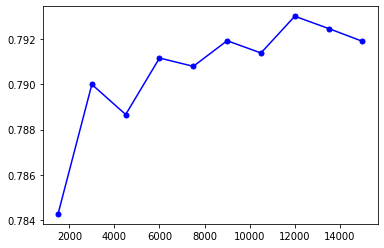

In [92]:
%%time
# Calculate training and test mean and std
train_sizes, train_scores, test_scores = learning_curve(estimator=clf, 
                                                        X=X_train, 
                                                        y=y_train.values.ravel(), 
                                                        cv=5, 
                                                        train_sizes=np.linspace(0.1, 1, 10),
                                                        n_jobs=1)
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)
plt.plot(train_sizes, train_mean, color='blue', marker='o', markersize=5, label='Training Accuracy')

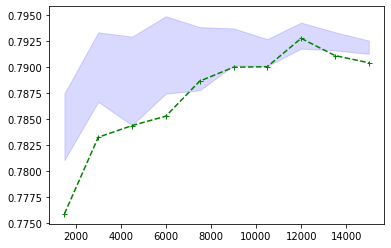

In [93]:
plt.fill_between(train_sizes, train_mean + train_std, train_mean - train_std, alpha=0.15, color='blue')
plt.plot(train_sizes, test_mean, color='green', marker='+', markersize=5, linestyle='--', label='Validation Accuracy')

## Hyperparameter Search

In [94]:
from warnings import simplefilter
from sklearn.exceptions import ConvergenceWarning
simplefilter("ignore", category=ConvergenceWarning)

In [95]:
param_grid = {
    'classifier__penalty': ['l1', 'l2'],
    'classifier__C': [0.001, 0.003, 0.006, 0.009, 0.01, 0.03, 0.03, 0.09,  0.1, 1, 10, 100]
}

model_lr = model_selection.GridSearchCV(clf, param_grid=param_grid, cv=5)

In [96]:
%%time
model_lr = model_lr.fit(X_train, y_train.values.ravel())

CPU times: user 48.2 s, sys: 256 ms, total: 48.4 s
Wall time: 48.5 s


In [97]:
metrics.confusion_matrix(y_train, model_lr.predict(X_train))

array([[12268,  2212],
       [ 1687,  2584]])

In [98]:
metrics.confusion_matrix(y_test, model_lr.predict(X_test))

array([[3064,  510],
       [ 457,  657]])

In [99]:
train_acc = metrics.accuracy_score(y_train, model_lr.predict(X_train))
test_acc = metrics.accuracy_score(y_test, model_lr.predict(X_test))
train_rec = metrics.recall_score(y_train, model_lr.predict(X_train))
test_rec = metrics.recall_score(y_test, model_lr.predict(X_test))
train_roc = metrics.roc_auc_score(y_train, model_lr.predict(X_train))
test_roc = metrics.roc_auc_score(y_test, model_lr.predict(X_test))
train_f1 = metrics.f1_score(y_train, model_lr.predict(X_train))
test_f1 = metrics.f1_score(y_test, model_lr.predict(X_test))
print(f"""
Train: 
    acc->{train_acc:.2}, rec->{train_rec:.2}
    roc->{train_roc:.2}
    f1->{train_f1:.2}
Test: 
    acc->{test_acc:.2}, rec->{test_rec:.2}
    roc->{test_roc:.2}
    f1->{test_f1:.2}""")


Train: 
    acc->0.79, rec->0.61
    roc->0.73
    f1->0.57
Test: 
    acc->0.79, rec->0.59
    roc->0.72
    f1->0.58


In [100]:
model_lr.best_params_

{'classifier__C': 0.09, 'classifier__penalty': 'l2'}

In [101]:
param_grid = {
    'classifier__penalty': ['l1', 'l2'],
    'classifier__C': [0.05, 0.06, 0.07, 0.08, 0.09]
}

model_lr = model_selection.GridSearchCV(clf, param_grid=param_grid, cv=5)

model_lr = model_lr.fit(X_train, y_train.values.ravel())

In [102]:
metrics.confusion_matrix(y_train, model_lr.predict(X_train))

array([[12268,  2212],
       [ 1687,  2584]])

In [103]:
metrics.confusion_matrix(y_test, model_lr.predict(X_test))

array([[3064,  510],
       [ 457,  657]])

In [104]:
metrics.accuracy_score(y_train, model_lr.predict(X_train)), metrics.recall_score(y_train, model_lr.predict(X_train))

(0.792064423230761, 0.6050105361741981)

In [105]:
metrics.accuracy_score(y_test, model_lr.predict(X_test)), metrics.recall_score(y_test, model_lr.predict(X_test))

(0.7937286689419796, 0.5897666068222621)

In [106]:
model_lr.best_params_

{'classifier__C': 0.09, 'classifier__penalty': 'l2'}

## Importancia de las variables

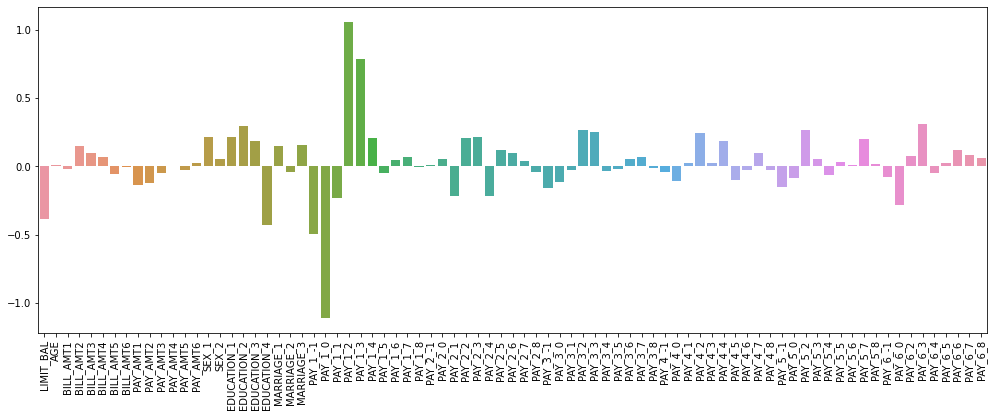

In [210]:
classifier = model_lr.best_estimator_.named_steps["classifier"]
importance = classifier.coef_[0]

#for i,v in enumerate(importance):
#    print(f'Feature: {i}, Score: {v:.5f}')

var_names = list(model_lr.best_estimator_['preprocessor']._iter(fitted=True))[1][1].get_feature_names(['SEX', 'EDUCATION',
                                                   'MARRIAGE', 'PAY_1', 'PAY_2',
                                                   'PAY_3', 'PAY_4', 'PAY_5',
                                                   'PAY_6'])

fig, ax = plt.subplots(figsize=(17, 6))
importance_plot = sns.barplot(ax=ax, x=numeric_features + list(var_names), y=importance)
for item in importance_plot.get_xticklabels():
    item.set_rotation(90)

array(['SEX_1', 'SEX_2', 'EDUCATION_1', 'EDUCATION_2', 'EDUCATION_3',
       'EDUCATION_4', 'MARRIAGE_1', 'MARRIAGE_2', 'MARRIAGE_3',
       'PAY_1_-1', 'PAY_1_0', 'PAY_1_1', 'PAY_1_2', 'PAY_1_3', 'PAY_1_4',
       'PAY_1_5', 'PAY_1_6', 'PAY_1_7', 'PAY_1_8', 'PAY_2_-1', 'PAY_2_0',
       'PAY_2_1', 'PAY_2_2', 'PAY_2_3', 'PAY_2_4', 'PAY_2_5', 'PAY_2_6',
       'PAY_2_7', 'PAY_2_8', 'PAY_3_-1', 'PAY_3_0', 'PAY_3_1', 'PAY_3_2',
       'PAY_3_3', 'PAY_3_4', 'PAY_3_5', 'PAY_3_6', 'PAY_3_7', 'PAY_3_8',
       'PAY_4_-1', 'PAY_4_0', 'PAY_4_1', 'PAY_4_2', 'PAY_4_3', 'PAY_4_4',
       'PAY_4_5', 'PAY_4_6', 'PAY_4_7', 'PAY_4_8', 'PAY_5_-1', 'PAY_5_0',
       'PAY_5_2', 'PAY_5_3', 'PAY_5_4', 'PAY_5_5', 'PAY_5_6', 'PAY_5_7',
       'PAY_5_8', 'PAY_6_-1', 'PAY_6_0', 'PAY_6_2', 'PAY_6_3', 'PAY_6_4',
       'PAY_6_5', 'PAY_6_6', 'PAY_6_7', 'PAY_6_8'], dtype=object)